In [1]:
from src import DataGenerator
from src import KalmanFilter

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import seaborn as sns

## Parameters

In [2]:
date_start = datetime(2022, 1, 1)
date_end = datetime(2022, 7, 31)

initial_value = 6
cov_matrix = 0.3
sampling_variance = 0.5 #1.5
seed = 40

## Generate Time-Series

In [3]:
time_series = DataGenerator.SingleLognormalTimeSeries(
    date_start,
    date_end,
    initial_value,
    cov_matrix,
    sampling_variance, 
    seed
)

time_series.generate_time_series()
df = time_series.time_series_data

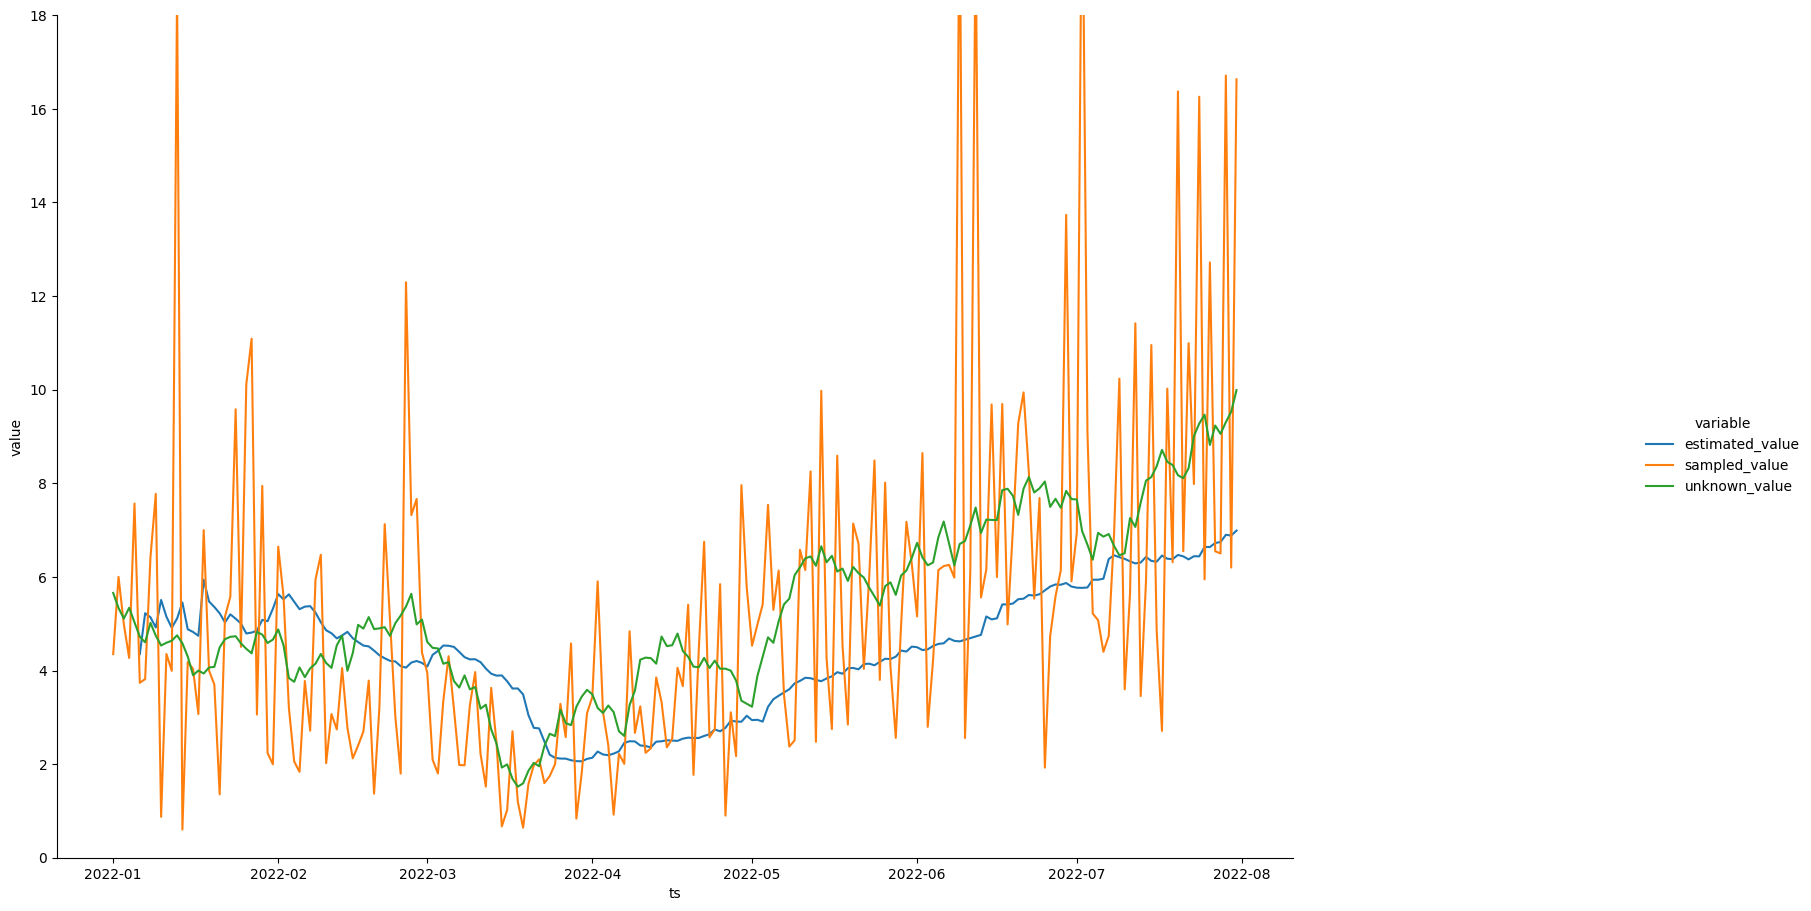

In [4]:
kf = KalmanFilter.KalmanFilterModel(time_variance=0.01, value_col_name='sampled_value')
forecast_df = kf.apply_kf(time_series.time_series_data)
forecast_df['estimated_value'] = forecast_df['updated_value'].shift(5)

forecast_df = forecast_df[['ts', 'estimated_value', 'sampled_value', 'unknown_value']]
forecast_df = pd.melt(forecast_df, id_vars='ts', value_vars=['estimated_value', 'sampled_value', 'unknown_value'])

g = sns.relplot(forecast_df, x='ts', y='value', hue='variable', kind='line', facet_kws={'ylim': [0, 18]})
g.figure.set_size_inches(20, 10)

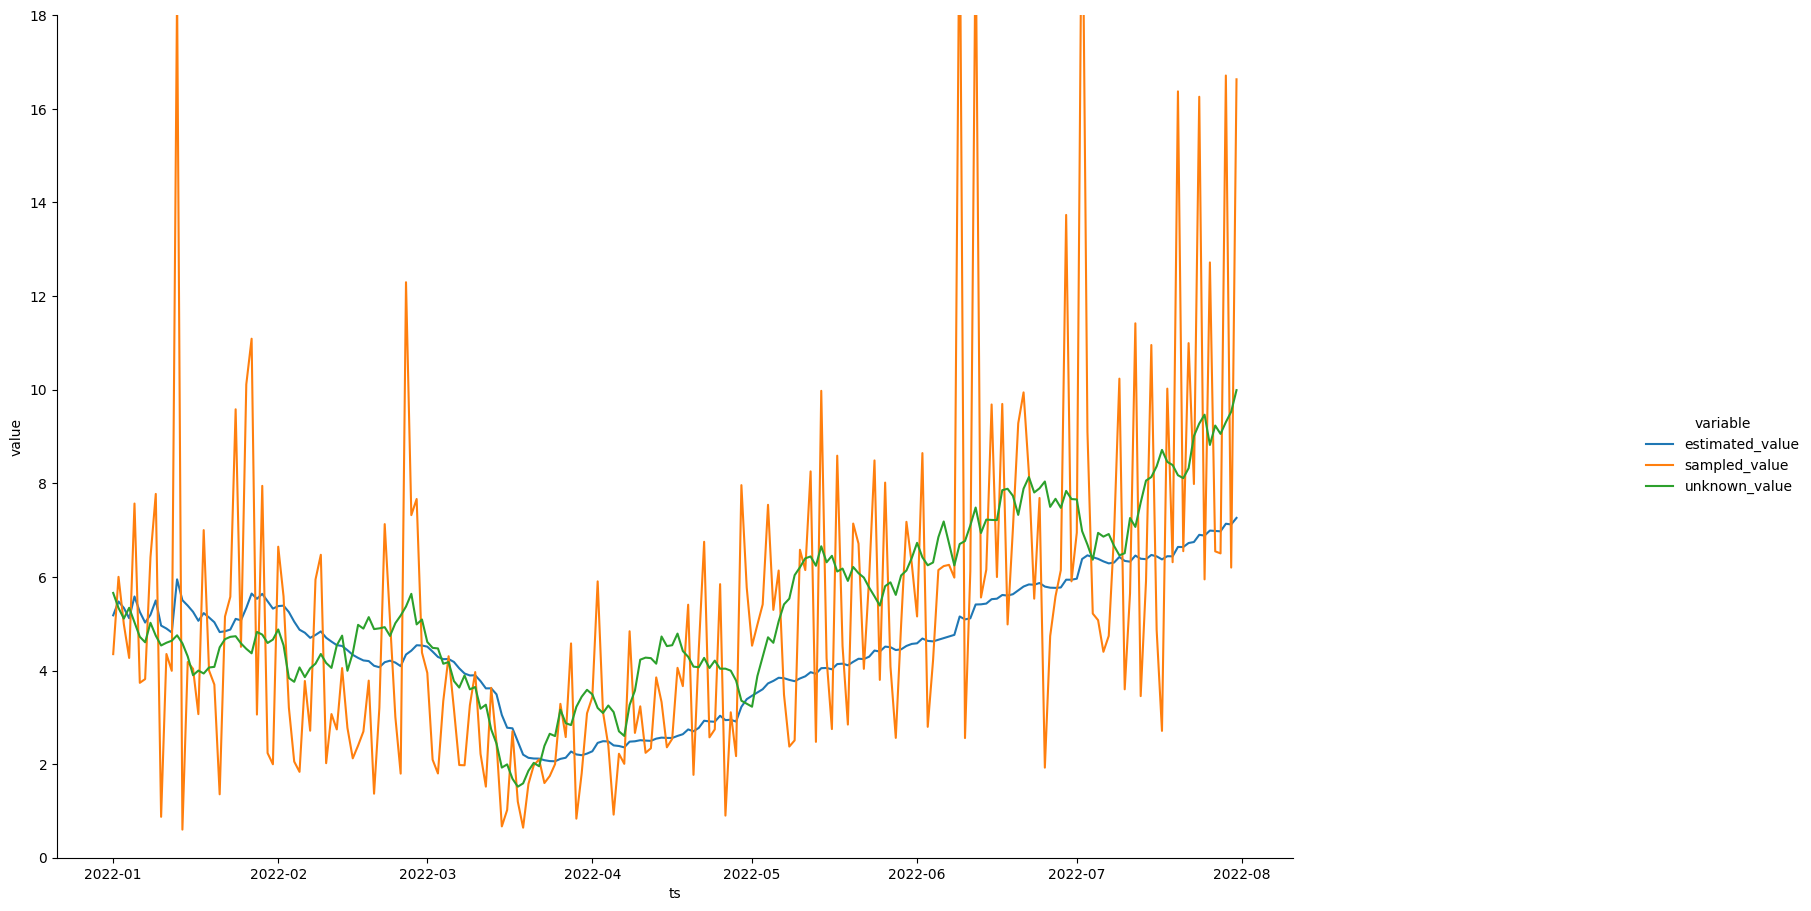

In [5]:
kf = KalmanFilter.KalmanFilterModel(prior_value=6, prior_variance=9, time_variance=0.01, value_col_name='sampled_value')
forecast_df = kf.apply_kf(time_series.time_series_data)
forecast_df['estimated_value'] = forecast_df['updated_value']

forecast_df = forecast_df[['ts', 'estimated_value', 'sampled_value', 'unknown_value']]
forecast_df = pd.melt(forecast_df, id_vars='ts', value_vars=['estimated_value', 'sampled_value', 'unknown_value'])

g = sns.relplot(forecast_df, x='ts', y='value', hue='variable', kind='line', facet_kws={'ylim': [0, 18]})
g.figure.set_size_inches(20, 10)

## Find optimal calibration for time variance for the KF

In [6]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [7]:
def kf_error(time_var):
    kf = KalmanFilter.KalmanFilterModel(time_variance=time_var, value_col_name='sampled_value')
    forecast_df = kf.apply_kf(time_series.time_series_data)
    forecast_df['updated_value'] = forecast_df['updated_value'].shift(5)
    df = forecast_df.copy().dropna()
    return mean_squared_error(df['updated_value'], df['sampled_value'])

optim = minimize(kf_error, 0.1, constraints = {'type': 'ineq', 'fun': lambda x:  x[0]})
optim

     fun: 10.84030311199818
     jac: array([0.00121629])
 message: 'Optimization terminated successfully'
    nfev: 6
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.10158008])

In [8]:
def ideal_kf_error(time_var):
    kf = KalmanFilter.KalmanFilterModel(time_variance=time_var, value_col_name='sampled_value')
    forecast_df = kf.apply_kf(time_series.time_series_data)
    forecast_df['updated_value'] = forecast_df['updated_value'].shift(5)
    df = forecast_df.copy().dropna()
    return mean_squared_error(df['updated_value'], df['unknown_value'])

optim = minimize(ideal_kf_error, 0.1, constraints = {'type': 'ineq', 'fun': lambda x:  x[0]})
optim

     fun: 1.2180953927507334
     jac: array([0.00107265])
 message: 'Optimization terminated successfully'
    nfev: 12
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.12229859])